In [ ]:
from google.colab import files
files.upload()

In [18]:
!nvidia-smi

Tue Nov 16 10:09:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    71W / 149W |   4536MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10

100% 585M/586M [00:10<00:00, 38.6MB/s]
100% 586M/586M [00:10<00:00, 58.4MB/s]


In [6]:
import zipfile
unzip = zipfile.ZipFile("animals10.zip","r")
unzip.extractall()
unzip.close()

In [7]:
import cv2

img = cv2.imread("/content/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg")

img.shape

(225, 300, 3)

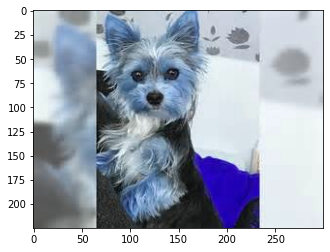

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [9]:
img_dir = "/content/raw-img"

In [10]:
import tensorflow as tf

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          rotation_range=0.2,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          zoom_range=0.2,
                                                          horizontal_flip=True,
                                                          vertical_flip = True,
                                                          validation_split = 0.2
                                                          
                                                          )

In [11]:
import tensorflow as tf

train_data = img_gen.flow_from_directory(img_dir,
                                       target_size = (224,224),
                                       class_mode = "categorical",
                                       batch_size = 64,
                                       subset = "training"
                                       )

val_data = img_gen.flow_from_directory(img_dir,
                                        target_size = (224,224),
                                        class_mode = "categorical",
                                        batch_size = 64,
                                        subset = "validation"
                                        )



Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [12]:
image, label = train_data.next()
print(image.shape)
print(label.shape)

(64, 224, 224, 3)
(64, 10)


In [13]:
train_data_eff = tf.keras.preprocessing.image_dataset_from_directory(img_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 64,
                                                                     validation_split = 0.2,
                                                                     seed = 42,
                                                                     subset = "training"
                                                                     )

val_data_eff = tf.keras.preprocessing.image_dataset_from_directory(img_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 64,
                                                                   validation_split = 0.2,
                                                                   seed = 42,
                                                                   subset = "validation"
                                                                   )

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [14]:
for image, label   in train_data_eff.take(1):
  print(image.shape)
  print(label.shape)
  break


(64, 224, 224, 3)
(64, 10)


In [27]:
# building a CNN 

import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             layers.Conv2D(filters= 23, kernel_size= 2, activation= "relu", input_shape = (224,224,3)),
                             layers.BatchNormalization(),
                             layers.Dropout(0.2),
                             layers.Conv2D(filters= 23, kernel_size = 2, activation= "relu"),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size = 2),
                             layers.Dropout(0.2),
                             layers.Conv2D(filters= 23, kernel_size = 2, activation= "relu"),
                             layers.BatchNormalization(),
                             layers.Dropout(0.2),
                             layers.Conv2D(filters= 23, kernel_size= 2, activation="relu"),
                             layers.MaxPooling2D(pool_size= 2),
                             layers.Flatten(),


                             layers.Dense(256, activation = "relu"),
                             layers.Dense(128, activation = "relu"),
                             layers.Dense(64, activation = "relu"),
                             layers.Dense(10, activation= "softmax")

])



In [28]:
# compiling the model

model.compile(
    loss= tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [35]:
# fittin data to the model

model.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data)
          )

Epoch 1/5
328/328 [==============================] - 381s 1s/step - loss: 2.7327 - accuracy: 0.2289 - val_loss: 2.3460 - val_accuracy: 0.1860
Epoch 2/5
328/328 [==============================] - 368s 1s/step - loss: 1.9994 - accuracy: 0.3000 - val_loss: 2.2074 - val_accuracy: 0.2102
Epoch 3/5
328/328 [==============================] - 361s 1s/step - loss: 1.9037 - accuracy: 0.3343 - val_loss: 2.0543 - val_accuracy: 0.2783
Epoch 4/5
328/328 [==============================] - 361s 1s/step - loss: 1.8183 - accuracy: 0.3672 - val_loss: 1.8878 - val_accuracy: 0.3398
Epoch 5/5
328/328 [==============================] - 360s 1s/step - loss: 1.7498 - accuracy: 0.3906 - val_loss: 1.9215 - val_accuracy: 0.3308


In [36]:
# resnetV50 model

import tensorflow as tf

res_base = tf.keras.applications.ResNet50(include_top= False)

res_base.trainable = False

In [37]:
#buildinb resnet model
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = res_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax")(x)

res_model = tf.keras.Model(inputs, outputs)



In [38]:
# compiling the model

res_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [41]:
# fitting data to the model

res_model.fit( train_data,
             epochs = 5,
             steps_per_epoch = len(train_data),
             validation_data = val_data,
             validation_steps = len(val_data)
             )

Epoch 1/5
328/328 [==============================] - 407s 1s/step - loss: 2.1578 - accuracy: 0.2263 - val_loss: 2.1053 - val_accuracy: 0.2521
Epoch 2/5
328/328 [==============================] - 400s 1s/step - loss: 2.0946 - accuracy: 0.2602 - val_loss: 2.0652 - val_accuracy: 0.2706
Epoch 3/5
328/328 [==============================] - 400s 1s/step - loss: 2.0624 - accuracy: 0.2741 - val_loss: 2.0606 - val_accuracy: 0.2863
Epoch 4/5
328/328 [==============================] - 397s 1s/step - loss: 2.0401 - accuracy: 0.2897 - val_loss: 2.0236 - val_accuracy: 0.2800
Epoch 5/5
328/328 [==============================] - 401s 1s/step - loss: 2.0211 - accuracy: 0.2917 - val_loss: 2.0054 - val_accuracy: 0.3043


In [43]:
# tunning the model

res_base.trainable = True

for layer in res_base.layers[:-3]:
  res_base.trainable = False

res_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

res_model.fit(train_data,
              epochs = 5,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))

Epoch 1/5
328/328 [==============================] - 415s 1s/step - loss: 1.9970 - accuracy: 0.3055 - val_loss: 1.9856 - val_accuracy: 0.3035
Epoch 2/5
328/328 [==============================] - 394s 1s/step - loss: 1.9762 - accuracy: 0.3145 - val_loss: 1.9651 - val_accuracy: 0.3135
Epoch 3/5
328/328 [==============================] - 396s 1s/step - loss: 1.9669 - accuracy: 0.3155 - val_loss: 1.9660 - val_accuracy: 0.3169
Epoch 4/5
328/328 [==============================] - 400s 1s/step - loss: 1.9618 - accuracy: 0.3156 - val_loss: 1.9482 - val_accuracy: 0.3308
Epoch 5/5
328/328 [==============================] - 400s 1s/step - loss: 1.9498 - accuracy: 0.3305 - val_loss: 1.9683 - val_accuracy: 0.3217


In [44]:
# building model for efficientnet50
import tensorflow as tf

eff_base = tf.keras.applications.EfficientNetB5(include_top= False)

eff_base.trainable = False


115277824/115263384 [==============================] - 1s 0us/step


In [45]:
#buildinb resnet model
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224,224,3))

x = eff_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax")(x)

eff_model = tf.keras.Model(inputs, outputs)

In [46]:
# compiling the model

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [47]:
# fitting data to the model

eff_model.fit( train_data_eff,
             epochs = 5,
             steps_per_epoch = len(train_data_eff),
             validation_data = val_data_eff,
             validation_steps = len(val_data_eff)
             )

Epoch 1/5
328/328 [==============================] - 381s 1s/step - loss: 0.2767 - accuracy: 0.9447 - val_loss: 0.1099 - val_accuracy: 0.9696
Epoch 2/5
328/328 [==============================] - 355s 1s/step - loss: 0.1071 - accuracy: 0.9717 - val_loss: 0.0944 - val_accuracy: 0.9719
Epoch 3/5
328/328 [==============================] - 355s 1s/step - loss: 0.0843 - accuracy: 0.9767 - val_loss: 0.0899 - val_accuracy: 0.9729
Epoch 4/5
328/328 [==============================] - 354s 1s/step - loss: 0.0734 - accuracy: 0.9799 - val_loss: 0.0865 - val_accuracy: 0.9750
Epoch 5/5
328/328 [==============================] - 354s 1s/step - loss: 0.0643 - accuracy: 0.9831 - val_loss: 0.0859 - val_accuracy: 0.9740


In [48]:
# tunning the model

eff_base.trainable = True

for layer in eff_base.layers[:-5]:
  eff_base.trainable = False

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

eff_model.fit(train_data_eff,
              epochs = 5,
              steps_per_epoch = len(train_data_eff),
              validation_data = val_data_eff,
              validation_steps = len(val_data_eff))

Epoch 1/5
328/328 [==============================] - 371s 1s/step - loss: 0.0590 - accuracy: 0.9843 - val_loss: 0.0850 - val_accuracy: 0.9754
Epoch 2/5
328/328 [==============================] - 350s 1s/step - loss: 0.0504 - accuracy: 0.9874 - val_loss: 0.0872 - val_accuracy: 0.9759
Epoch 3/5
328/328 [==============================] - 351s 1s/step - loss: 0.0466 - accuracy: 0.9876 - val_loss: 0.0863 - val_accuracy: 0.9771
Epoch 4/5
328/328 [==============================] - 351s 1s/step - loss: 0.0416 - accuracy: 0.9895 - val_loss: 0.0869 - val_accuracy: 0.9757
Epoch 5/5
328/328 [==============================] - 351s 1s/step - loss: 0.0381 - accuracy: 0.9903 - val_loss: 0.0863 - val_accuracy: 0.9757


In [49]:
print(f"Resnet Accuracy: {res_model.evaluate(val_data)[1] * 100 : 0.2f} %")
print(f"Efficient Accuracy {eff_model.evaluate(val_data_eff)[1] * 100 : 0.2f} %")

82/82 [==============================] - 75s 911ms/step - loss: 1.9626 - accuracy: 0.3200
Resnet Accuracy:  32.00 %
82/82 [==============================] - 70s 845ms/step - loss: 0.0863 - accuracy: 0.9757
Efficient Accuracy  97.57 %


In [50]:
labels_name = val_data_eff.class_names
len(labels_name)

10

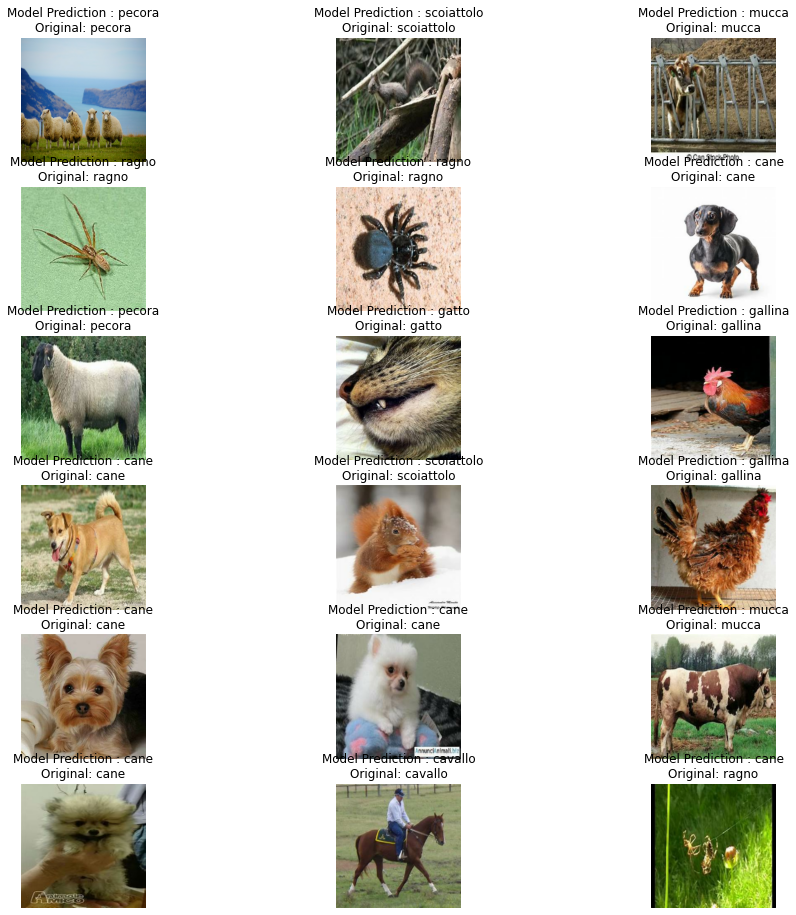

In [51]:
# predicting and visualizing the images

import tensorflow as tf
import matplotlib.pyplot as plt

plt.figure(figsize = (16,16))

for image,label in val_data_eff.take(1):
  model_prediction = eff_model.predict(image)

  for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}")
    plt.axis("off")
